## <center> Data Preprocessing

The data preprocessing steps involved the creation of a dataframe with various features derived from raster patches. Initially, the latitude and longitude coordinates at the center of each raster patch were calculated. Subsequently, statistical features for each band—specifically, mean, maximum, minimum, and range—were computed and incorporated into the dataframe. Moreover, composite indices such as NDVI, NDWI, SAVI, and EVI were created using the split window method. We have created this features so that we can assess how each feature is increasing or decreasing model's performance. To ensure these indices were within a certain range, the values were confined within predefined limits. Later, we kept only those which has the same spatial resolution and are being used in creating indices. And our choice of indices also influenced by the bands with same resoulution.

## Importing Necessary Modules

In [4]:
import rasterio
import rasterio.features
import rasterio.warp
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

## Data Access

In [39]:
directory_path = '/data/shared/Big-Geodata-Processing-2023-1A/Exercise3/EuroSAT_MS/'
subfolders = [ f.path for f in os.scandir(directory_path) if f.is_dir() ]

## Creating Dataframe from the dataset

In [ ]:
# Define the function to get the centroid
def get_cent(filename):
    with rasterio.open(filename) as dataset:
        mask = dataset.dataset_mask()
        for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):
            geom = rasterio.warp.transform_geom(dataset.crs, 'EPSG:4326', geom, precision=6)
            ls = list(geojson.utils.coords(geom))
            x = []
            y = []
            for row in ls:
                x.append(row[0])
                y.append(row[1])
            cent = [min(y) + (max(y) - min(y)) / 2, min(x) + (max(x) - min(x)) / 2]
    return cent

# Initialize the DataFrame
df_new = pd.DataFrame(columns=["Lat", "Lon", "Class"] + [f"Band_{i}_mean" for i in range(1, 14)] + [f"Band_{i}_min" for i in range(1, 14)] + [f"Band_{i}_max" for i in range(1, 14)])

# Loop through the folders and images
for i in range(len(subfolders)):
    image_path = subfolders[i]
    class_name = os.path.basename(image_path)
    all_images = [f for f in os.listdir(image_path) if os.path.isfile(join(image_path, f))]
    print(class_name, len(all_images))
    
    for j in range(len(all_images)):
        cent = get_cent(image_path+'/'+all_images[j])
        
        # Prepare lists for band statistics
        band_means = []
        band_mins = []
        band_maxs = []
        
        with rasterio.open(image_path+'/'+all_images[j]) as dataset:
            for k in range(1, 14):  # For bands 1 to 13
                band_data = dataset.read(k)
                band_means.append(np.mean(band_data))
                band_mins.append(np.min(band_data))
                band_maxs.append(np.max(band_data))
        
        # Create a new row with band statistics
        new_row = pd.DataFrame({
            "Lat": cent[0],
            "Lon": cent[1],
            "Class": class_name, 
            **{f"Band_{i}_mean": band_means[i - 1] if i <= len(band_means) else None for i in range(1, 14)},
            **{f"Band_{i}_min": band_mins[i - 1] if i <= len(band_mins) else None for i in range(1, 14)},
            **{f"Band_{i}_max": band_maxs[i - 1] if i <= len(band_maxs) else None for i in range(1, 14)}
        }, index=[0])
        
        # Concatenate the new row to the DataFrame
        df_new = pd.concat([df_new, new_row], ignore_index=True)

## Exporting Dataframe

In [ ]:
df_new.to_csv('Feature_Enginnered_Dataframe.csv')

## Reading New dataframe

In [5]:
df_new=  pd.read_csv('Feature_Enginnered_Dataframe.csv')

In [6]:
columns_to_keep = ['Lat', 'Lon', 'Class',
                   'Band_2_mean', 'Band_2_max', 'Band_2_min',
                   'Band_3_mean', 'Band_3_max', 'Band_3_min',
                   'Band_4_mean', 'Band_4_max', 'Band_4_min',
                   'Band_8_mean', 'Band_8_max', 'Band_8_min']

# Keep only the specified columns
df_new = df_new[columns_to_keep]

## Adding New Statistical Feature Column (Range)

In [7]:
bands_to_process = [2, 3, 4, 8]

for band in bands_to_process:
    min_col = f'Band_{band}_min'
    max_col = f'Band_{band}_max'
    range_col = f'Band_{band}_range'
    
    # Calculate the range and add it as a new column
    df_new[range_col] = df_new[max_col] - df_new[min_col]

## Adding New Composite Indices Column (NDVI, NDWI, SAVI, EVI)

In [8]:
# NDVI Calculation
df_new['NDVI_mean'] = (df_new['Band_8_mean'] - df_new['Band_4_mean']) / (df_new['Band_8_mean'] + df_new['Band_4_mean'])
df_new['NDVI_max'] = (df_new['Band_8_max'] - df_new['Band_4_min']) / (df_new['Band_8_max'] + df_new['Band_4_min'])
df_new['NDVI_min'] = (df_new['Band_8_min'] - df_new['Band_4_max']) / (df_new['Band_8_min'] + df_new['Band_4_max'])
df_new['NDVI_range'] = df_new['NDVI_max'] - df_new['NDVI_min']

for column in ['NDVI_mean', 'NDVI_max', 'NDVI_min', 'NDVI_range']:
    df_new[column] = np.clip(df_new[column], -1, 1)

# NDWI Calculation
df_new['NDWI_mean'] = (df_new['Band_3_mean'] - df_new['Band_8_mean']) / (df_new['Band_3_mean'] + df_new['Band_8_mean'])
df_new['NDWI_max'] = (df_new['Band_3_max'] - df_new['Band_8_min']) / (df_new['Band_3_max'] + df_new['Band_8_min'])
df_new['NDWI_min'] = (df_new['Band_3_min'] - df_new['Band_8_max']) / (df_new['Band_3_min'] + df_new['Band_8_max'])
df_new['NDWI_range'] = df_new['NDWI_max'] - df_new['NDWI_min']

for column in ['NDWI_mean', 'NDWI_max', 'NDWI_min', 'NDWI_range']:
    df_new[column] = np.clip(df_new[column], -1, 1)

# EVI Calculation
df_new['EVI_mean'] = 2.5 * (df_new['Band_8_mean'] - df_new['Band_4_mean']) / (df_new['Band_8_mean'] + (6 * df_new['Band_4_mean']) - (7.5 * df_new['Band_2_mean']) + 1)
df_new['EVI_max'] = 2.5 * (df_new['Band_8_max'] - df_new['Band_4_min']) / (df_new['Band_8_max'] + 6 * df_new['Band_4_max'] - 7.5 * df_new['Band_2_max'] + 1)
df_new['EVI_min'] = 2.5 * (df_new['Band_8_min'] - df_new['Band_4_max']) / (df_new['Band_8_min'] + 6 * df_new['Band_4_min'] - 7.5 * df_new['Band_2_min'] + 1)
df_new['EVI_range'] = df_new['EVI_max'] - df_new['EVI_min']

for column in ['EVI_mean', 'EVI_max', 'EVI_min', 'EVI_range']:
    df_new[column] = np.clip(df_new[column], 0, 1)


# SAVI Calculation
df_new['SAVI_mean'] = (df_new['Band_8_mean'] - df_new['Band_4_mean']) * (1 + 1.5) / (df_new['Band_8_mean'] + df_new['Band_4_mean'] + 1.5)
df_new['SAVI_max'] = (df_new['Band_8_max'] - df_new['Band_4_min']) * (1 + 1.5) / (df_new['Band_8_max'] + df_new['Band_4_max'] + 1.5)
df_new['SAVI_min'] = (df_new['Band_8_min'] - df_new['Band_4_max']) * (1 + 1.5) / (df_new['Band_8_min'] + df_new['Band_4_min'] + 1.5)
df_new['SAVI_range'] = df_new['SAVI_max'] - df_new['SAVI_min']

for column in ['SAVI_mean', 'SAVI_max', 'SAVI_min', 'SAVI_range']:
    df_new[column] = np.clip(df_new[column], -1, 1)

## Adding Index as the first column

In [9]:
# Create a new index column in the DataFrame
df_new.insert(0, 'Index', range(1, len(df_new) + 1))


In [10]:
df_new.head(5)

,Index,Lat,Lon,Class,Band_2_mean,Band_2_max,Band_2_min,Band_3_mean,Band_3_max,Band_3_min,...,NDWI_min,NDWI_range,EVI_mean,EVI_max,EVI_min,EVI_range,SAVI_mean,SAVI_max,SAVI_min,SAVI_range
0,1,47.017201,11.376195,HerbaceousVegetation,1073.490723,2182,589,1120.595703,2297,407,...,-0.834989,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,-1.000000,1.0
1,2,39.520964,-0.863959,HerbaceousVegetation,989.156250,1781,856,946.531738,1884,756,...,-0.597230,0.657145,0.000000,1.0,0.866900,1.000000,1.000000,1.0,-0.435452,1.0
2,3,39.560035,22.210556,HerbaceousVegetation,1210.727295,1742,891,1073.504150,1684,588,...,-0.744792,1.000000,0.000000,1.0,0.686459,1.000000,1.000000,1.0,-1.000000,1.0
3,4,41.812108,-0.918763,HerbaceousVegetation,1443.287598,2569,960,1518.321777,2988,912,...,-0.656949,0.975864,0.572829,1.0,1.000000,0.000000,0.360900,1.0,-1.000000,1.0
4,5,37.630254,-5.941201,HerbaceousVegetation,1063.884766,1520,865,1046.255615,1684,792,...,-0.611479,0.575969,1.000000,1.0,1.000000,0.141747,0.862109,1.0,-0.479154,1.0


## Checking Column Names

In [11]:
df_new.columns

Index(['Index', 'Lat', 'Lon', 'Class', 'Band_2_mean', 'Band_2_max',
       'Band_2_min', 'Band_3_mean', 'Band_3_max', 'Band_3_min', 'Band_4_mean',
       'Band_4_max', 'Band_4_min', 'Band_8_mean', 'Band_8_max', 'Band_8_min',
       'Band_2_range', 'Band_3_range', 'Band_4_range', 'Band_8_range',
       'NDVI_mean', 'NDVI_max', 'NDVI_min', 'NDVI_range', 'NDWI_mean',
       'NDWI_max', 'NDWI_min', 'NDWI_range', 'EVI_mean', 'EVI_max', 'EVI_min',
       'EVI_range', 'SAVI_mean', 'SAVI_max', 'SAVI_min', 'SAVI_range'],
      dtype='object')

## Checking the Range of Latitude and Longitude

In [12]:
min_value_lat = df_new['Lat'].min()
max_value_lat = df_new['Lat'].max()

min_value_lon = df_new['Lon'].min()
max_value_lon= df_new['Lon'].max()

print(f"The lat min value is: {min_value_lat} and max: {max_value_lat}")
print(f"The lat min value is: {min_value_lon} and max: {max_value_lon}")

The lat min value is: 27.967059 and max: 65.2378165
The lat min value is: -20.993892 and max: 33.5289755


## Cleaning the data

In [13]:
rows_with_nan = df_new[df_new.isna().any(axis=1)]

print("Rows with NaN values:")
print(rows_with_nan)

df_check = df_new[['NDVI_mean', 'NDVI_max', 'NDVI_min', 'NDWI_mean', 'NDWI_max',
       'NDWI_min', 'EVI_mean', 'EVI_max', 'EVI_min', 'SAVI_mean', 'SAVI_max',
       'SAVI_min', 'NDVI_range', 'NDWI_range', 'EVI_range', 'SAVI_range']]

for column_name in df_check.columns:
    inf_count = np.isinf(df_new[column_name]).sum()
    print(f'Number of infinite values in column "{column_name}": {inf_count}')
    

rows_with_inf = df_check[df_check.apply(lambda x: np.any(np.isinf(x)), axis=1)]

print("Rows with infinite values:")
print(rows_with_inf)


Rows with NaN values:
Empty DataFrame
Columns: [Index, Lat, Lon, Class, Band_2_mean, Band_2_max, Band_2_min, Band_3_mean, Band_3_max, Band_3_min, Band_4_mean, Band_4_max, Band_4_min, Band_8_mean, Band_8_max, Band_8_min, Band_2_range, Band_3_range, Band_4_range, Band_8_range, NDVI_mean, NDVI_max, NDVI_min, NDVI_range, NDWI_mean, NDWI_max, NDWI_min, NDWI_range, EVI_mean, EVI_max, EVI_min, EVI_range, SAVI_mean, SAVI_max, SAVI_min, SAVI_range]
Index: []

[0 rows x 36 columns]
Number of infinite values in column "NDVI_mean": 0
Number of infinite values in column "NDVI_max": 0
Number of infinite values in column "NDVI_min": 0
Number of infinite values in column "NDWI_mean": 0
Number of infinite values in column "NDWI_max": 0
Number of infinite values in column "NDWI_min": 0
Number of infinite values in column "EVI_mean": 0
Number of infinite values in column "EVI_max": 0
Number of infinite values in column "EVI_min": 0
Number of infinite values in column "SAVI_mean": 0
Number of infinite val

In [14]:
df_new = df_new.drop(7212)
df_new = df_new.drop(11513)
df_new = df_new.drop(22820)

## Plotting 

C:\Users\User\AppData\Local\Temp\ipykernel_10956\3805531101.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


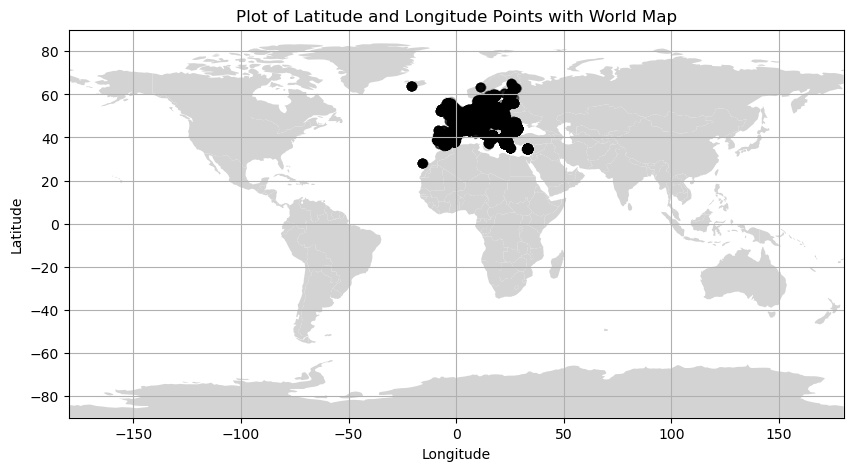

In [15]:
# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract latitude and longitude columns
lats = df_new['Lat']
lons = df_new['Lon']

# Plotting the points on a scatter plot
plt.figure(figsize=(10, 8))

# Plot the world map
world.plot(ax=plt.gca(), color='lightgrey')

# Scatter plot of latitude and longitude
plt.scatter(lons, lats, alpha=0.1, color='black')  # Plotting latitude vs longitude

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Latitude and Longitude Points with World Map')

# Set axis limits to simulate zoom level (adjust these values to zoom in or out)
# For example, latitude from -90 to 90 and longitude from -180 to 180 will cover the whole world
plt.xlim(-180, 180)  # Set longitude limits
plt.ylim(-90, 90)  # Set latitude limits

plt.grid(True)
plt.show()

In [16]:
import geopandas as gpd

# Define the latitude and longitude ranges
lat_min_1 = 27.967059
lat_max_1 = 65.2378165
lat_min_2 = -20.993892
lat_max_2 = 33.5289755

# Load the world boundaries dataset from Natural Earth
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter countries within the latitude and longitude ranges
countries_in_range_1 = world.cx[:, lat_min_1:lat_max_1]
countries_in_range_2 = world.cx[:, lat_min_2:lat_max_2]

# Print the countries within the specified latitude ranges
print("Countries in the first latitude range:")
print(countries_in_range_1['name'])

print("\nCountries in the second latitude range:")
print(countries_in_range_2['name'])


Countries in the first latitude range:
3                        Canada
4      United States of America
5                    Kazakhstan
6                    Uzbekistan
18                       Russia
                 ...           
170            Bosnia and Herz.
171             North Macedonia
172                      Serbia
173                  Montenegro
174                      Kosovo
Name: name, Length: 79, dtype: object

Countries in the second latitude range:
0                          Fiji
1                      Tanzania
2                     W. Sahara
4      United States of America
7              Papua New Guinea
                 ...           
167                  Somaliland
168                      Uganda
169                      Rwanda
175         Trinidad and Tobago
176                    S. Sudan
Name: name, Length: 114, dtype: object


C:\Users\User\AppData\Local\Temp\ipykernel_10956\4248023780.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [17]:
df_new.to_csv('Added_Features.csv')

In [18]:
df_new.head()

,Index,Lat,Lon,Class,Band_2_mean,Band_2_max,Band_2_min,Band_3_mean,Band_3_max,Band_3_min,...,NDWI_min,NDWI_range,EVI_mean,EVI_max,EVI_min,EVI_range,SAVI_mean,SAVI_max,SAVI_min,SAVI_range
0,1,47.017201,11.376195,HerbaceousVegetation,1073.490723,2182,589,1120.595703,2297,407,...,-0.834989,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,-1.000000,1.0
1,2,39.520964,-0.863959,HerbaceousVegetation,989.156250,1781,856,946.531738,1884,756,...,-0.597230,0.657145,0.000000,1.0,0.866900,1.000000,1.000000,1.0,-0.435452,1.0
2,3,39.560035,22.210556,HerbaceousVegetation,1210.727295,1742,891,1073.504150,1684,588,...,-0.744792,1.000000,0.000000,1.0,0.686459,1.000000,1.000000,1.0,-1.000000,1.0
3,4,41.812108,-0.918763,HerbaceousVegetation,1443.287598,2569,960,1518.321777,2988,912,...,-0.656949,0.975864,0.572829,1.0,1.000000,0.000000,0.360900,1.0,-1.000000,1.0
4,5,37.630254,-5.941201,HerbaceousVegetation,1063.884766,1520,865,1046.255615,1684,792,...,-0.611479,0.575969,1.000000,1.0,1.000000,0.141747,0.862109,1.0,-0.479154,1.0
